In [1]:
import os, sys, io
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

from numpy import sqrt, exp, pi, square
from tqdm import tqdm

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if sci:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = '$Number\ of\ Entries$')
    else:
        pass

# Make multihist even easier to use
from contextlib import contextmanager
@contextmanager
def plotting2d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global mh
    mh.plot(log_scale = True, cmap=plt.get_cmap('viridis'), alpha = 1.0 )

@contextmanager
def plotting1d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global ph
    ph.plot()
    
@contextmanager
def nostdout():
    global save_stdout
    save_stdout = sys.stdout
    sys.stdout = open('Dummy', 'w+')
    yield
    sys.stdout = save_stdout

In [3]:
# Read pickled real merged data
df_ab_copy = pd.read_pickle('/scratch/midway2/zhut/data/SingleScatter/data/pickles/pax_v6.8.0_ab_sr1_cut.pkl')
df_rn_copy = pd.read_pickle('/scratch/midway2/zhut/data/SingleScatter/data/pickles/pax_v6.8.0_rn_sr1_cut.pkl')

In [4]:
# Pass Data through other lax cuts
from hax import cuts
import hax
hax.init()

cuts_copy = ['CutFiducialCylinder1T',
             'CutInteractionPeaksBiggest',
             'CutDAQVeto',
             'CutS2Tails',
             'CutS1MaxPMT',
             'CutS1AreaFractionTop',
             'CutS2PatternLikelihood',
             'CutS2AreaFractionTop',
            ]
for cut in cuts_copy:
    df_rn_copy = cuts.selection(df_rn_copy, df_rn_copy[cut], desc = cut)
chistory_rn = cuts.history(df_rn_copy)

for cut in cuts_copy:
    df_ab_copy = cuts.selection(df_ab_copy, df_ab_copy[cut], desc = cut)
chistory_ab = cuts.history(df_ab_copy)

CutFiducialCylinder1T selection: 6892799 rows removed (9.50% passed)
CutInteractionPeaksBiggest selection: 49476 rows removed (93.16% passed)
CutDAQVeto selection: 60718 rows removed (90.99% passed)
CutS2Tails selection: 80248 rows removed (86.91% passed)
CutS1MaxPMT selection: 48770 rows removed (90.85% passed)
CutS1AreaFractionTop selection: 16033 rows removed (96.69% passed)
CutS2PatternLikelihood selection: 111114 rows removed (76.26% passed)
CutS2AreaFractionTop selection: 626 rows removed (99.82% passed)
CutFiducialCylinder1T selection: 1264876 rows removed (7.02% passed)
CutInteractionPeaksBiggest selection: 18811 rows removed (80.31% passed)
CutDAQVeto selection: 2277 rows removed (97.03% passed)
CutS2Tails selection: 12235 rows removed (83.57% passed)
CutS1MaxPMT selection: 8408 rows removed (86.49% passed)
CutS1AreaFractionTop selection: 3917 rows removed (92.72% passed)
CutS2PatternLikelihood selection: 5091 rows removed (89.80% passed)
CutS2AreaFractionTop selection: 155 ro

In [6]:
# Pass input to fax simulation
df_ab_ = df_ab_copy[(df_ab_copy.cs2<1.1e4) & (df_ab_copy.CutS2SingleScatterSimple)]
print(len(df_ab_))
df_ab_.to_pickle('/home/zhut/sim/processing/montecarlo/fax_waveform_py/S2_Single_Scatter_Sim.pkl')

# In fax_waveform_py.fax_production_main.py
# set config name = 'S2_Single_Scatter_Sim',
#            number_job = 39,
#            number_event_per_job = 100,
# in fax_waveform_py.fax_production_process.py
# in line 95 replace CreateFake() by CreateFakeFromPickle()

3913


In [26]:
# Read pickled fax simulated single scatter data
faxfolder = '/project2/lgrandi/zhut/sim/S2_Single_Scatter_Sim/merged'
df_fax = pd.concat([pd.read_pickle(os.path.join(faxfolder, f)) for f in os.listdir(faxfolder) if '.pkl' in f])
df_fax['r'] = sqrt(square(df_fax['x_pax']) + square(df_fax['y_pax']))

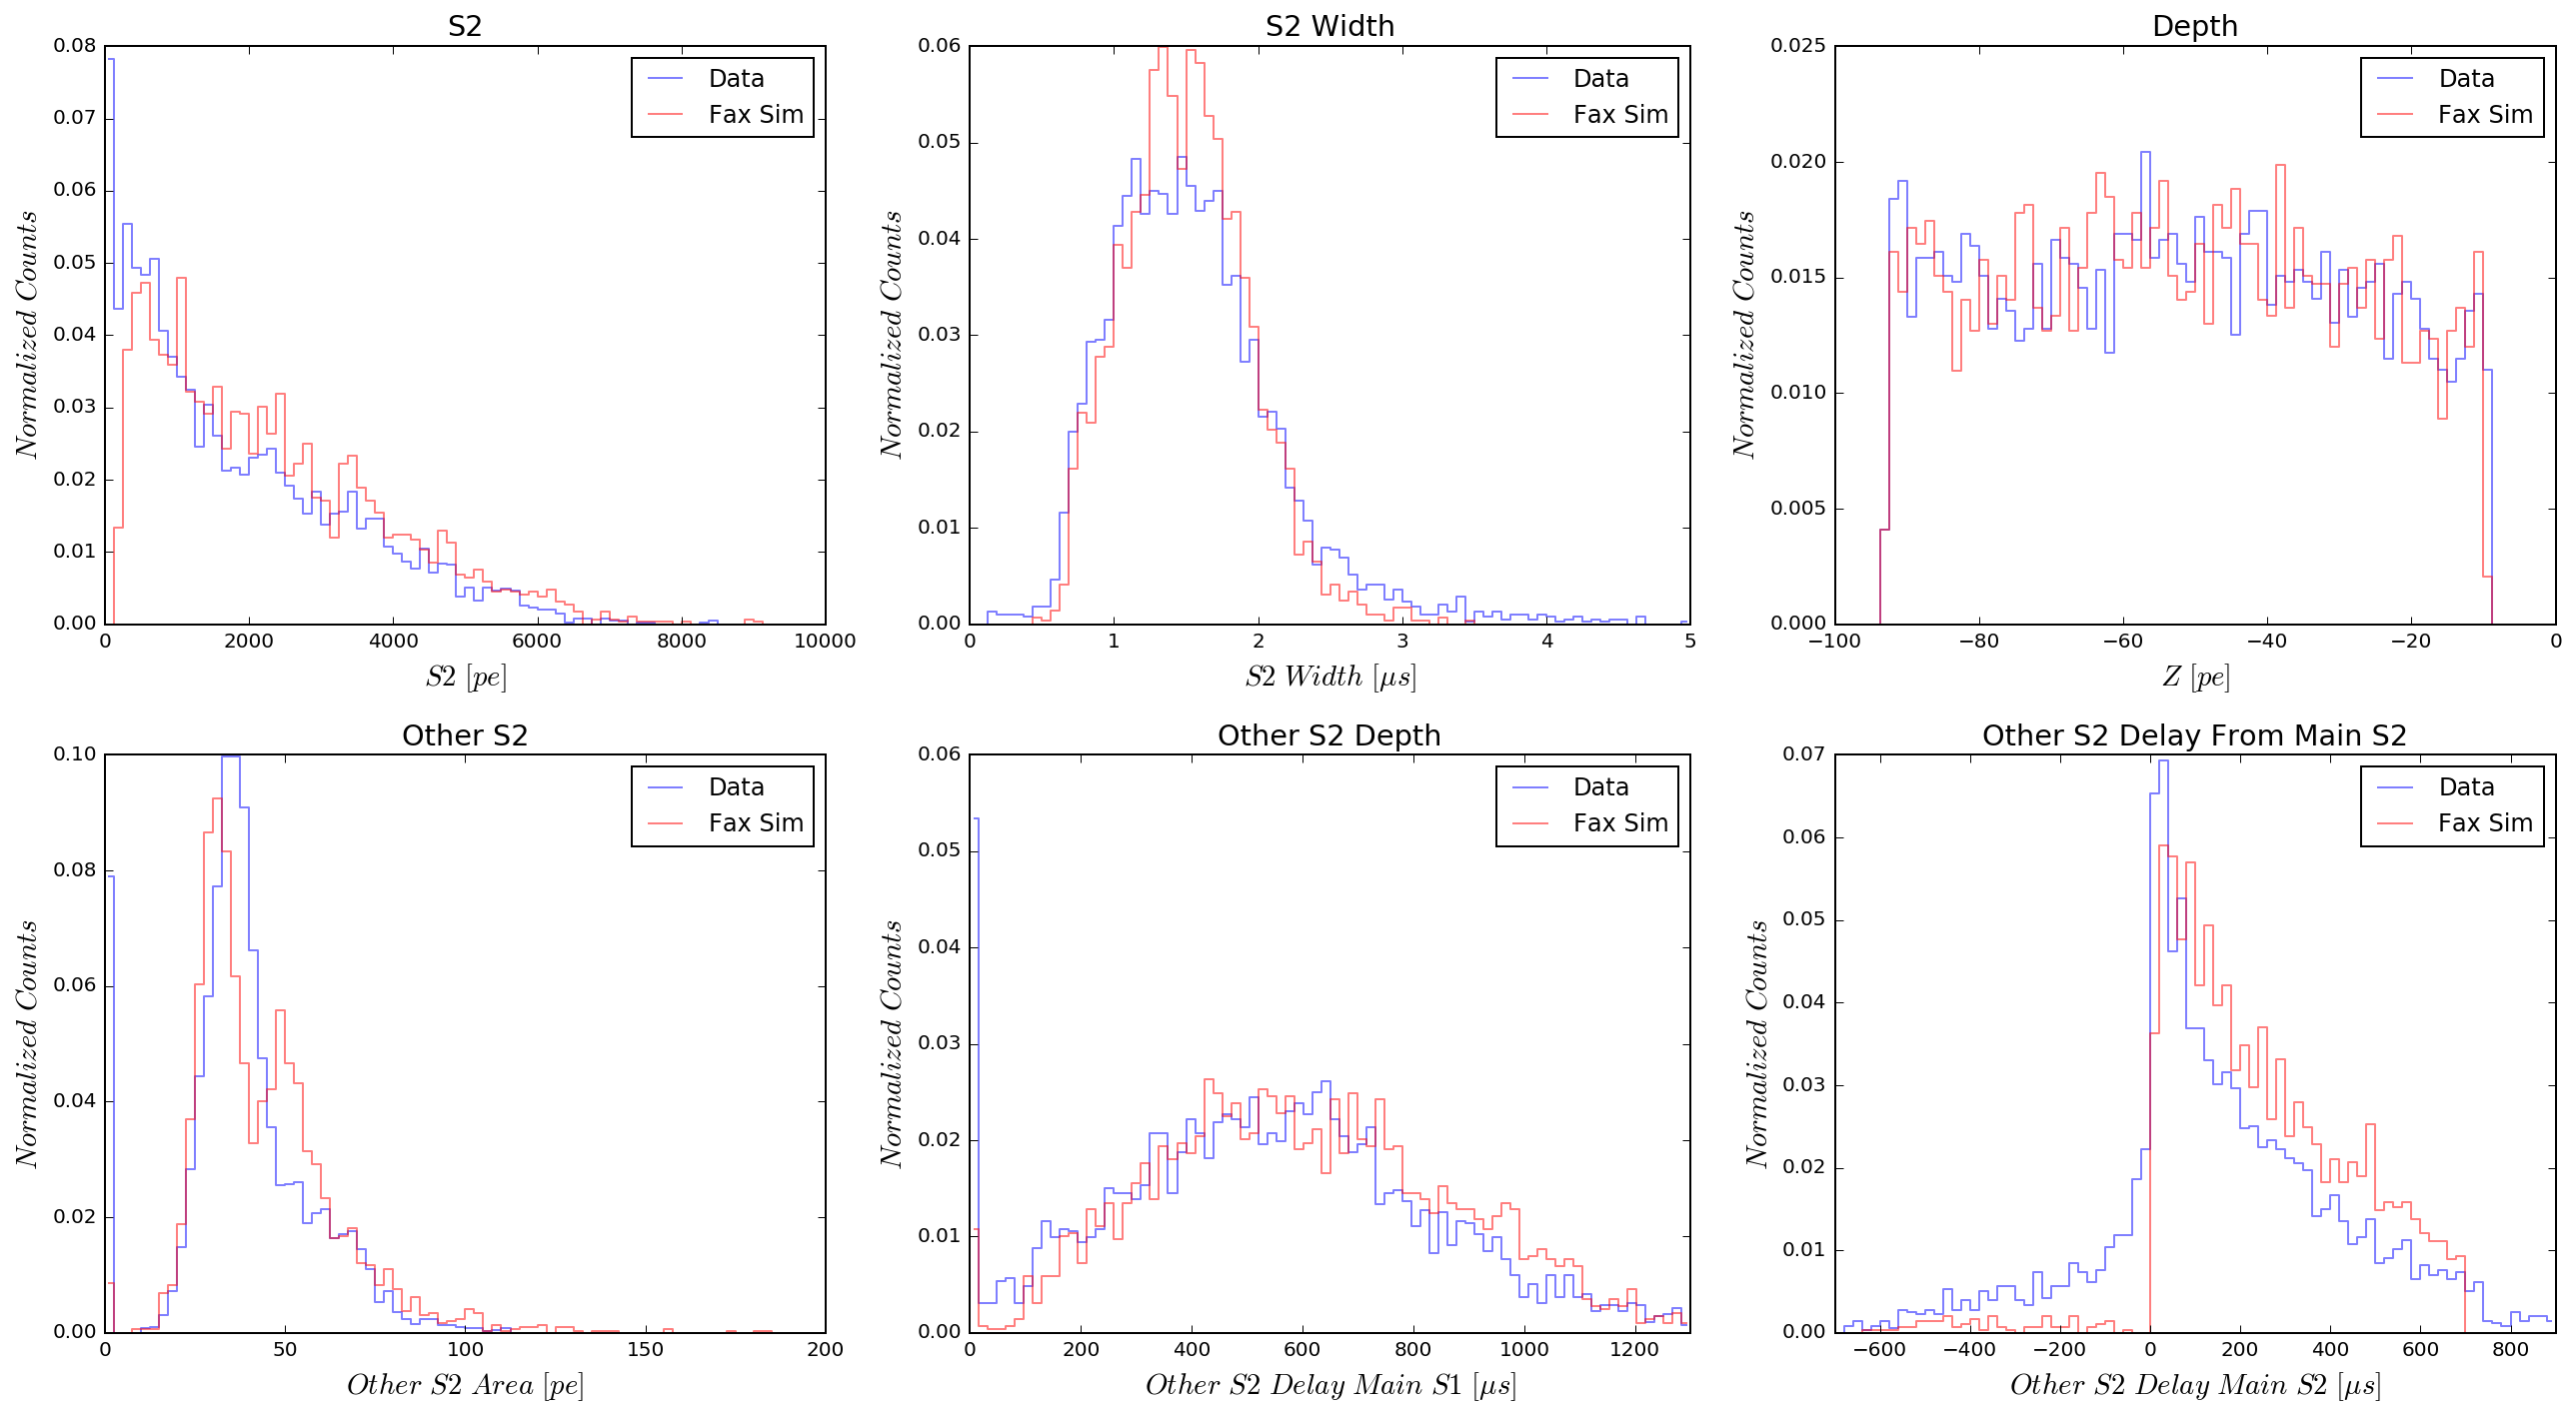

In [28]:
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()

ops = [dict(color = 'b', alpha = 0.5, ),
       dict(color = 'r', alpha = 0.5, ),
       dict(color = 'b', alpha = 0.5,),
       dict(color = 'r', alpha = 0.5, ),
      ]

lines = ['df_ab_', 'df_fax_']
sel_basics = lambda df:df[(df.s2 > 200)
                          & (df.z > -93) 
                          & (df.z < -9)
                         ]

df_fax_ = sel_basics(df_fax)

#####################################################################
ax = fig.add_subplot(231)
argx = '{df}.s2'

for ix, df in enumerate(lines):
    ph = Hist1d(eval(argx.format(df = df)), range = [0, 1e4], bins = 80)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
    ph.plot(**ops[ix])

plt.legend(['Data', 'Fax Sim'])
plt_config(title = 'S2', xlabel = '$S2\ [pe]$', ylabel = '$Normalized\ Counts$', 
           xbounds = [0,1e4])

#####################################################################
ax = fig.add_subplot(232)
argx = '{df}.s2_range_50p_area/1e3'

for ix, df in enumerate(lines):
    ph = Hist1d(eval(argx.format(df = df)), range = [0,5], bins = 80)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
    ph.plot(**ops[ix])

plt.legend(['Data', 'Fax Sim'])
plt_config(title = 'S2 Width', xlabel = r'$S2\ Width\ [\mu s]$', ylabel = '$Normalized\ Counts$', 
           xbounds = [0,5])

#####################################################################
ax = fig.add_subplot(233)
argx = '{df}.z'

for ix, df in enumerate(lines):
    ph = Hist1d(eval(argx.format(df = df)), range = [-100,0], bins = 80)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
    ph.plot(**ops[ix])

plt.legend(['Data', 'Fax Sim'])
plt_config(title = 'Depth', xlabel = '$Z\ [pe]$', ylabel = '$Normalized\ Counts$', 
           xbounds = [-100,0])

#####################################################################
ax = fig.add_subplot(234)
argx = '{df}.largest_other_s2'

for ix, df in enumerate(lines):
    ph = Hist1d(eval(argx.format(df = df)), range = [0, 200], bins = 80)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
    ph.plot(**ops[ix])

plt.legend(['Data', 'Fax Sim'])
plt_config(title = 'Other S2', xlabel = '$Other\ S2\ Area\ [pe]$', ylabel = '$Normalized\ Counts$', 
           xbounds = [0,200])

#####################################################################
ax = fig.add_subplot(235)
argx = ['{df}.other_s2_delay_main_s1/1e3','{df}.largest_other_s2_delay_main_s1/1e3']

for ix, df in enumerate(lines):
    ph = Hist1d(eval(argx[ix].format(df = df)), range = [0,1300], bins = 80)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
    ph.plot(**ops[ix])

plt.legend(['Data', 'Fax Sim'])
plt_config(title = 'Other S2 Depth', xlabel = r'$Other\ S2\ Delay\ Main\ S1\ [\mu s]$', ylabel = '$Normalized\ Counts$', 
           xbounds = [0,1300])

#####################################################################
ax = fig.add_subplot(236)
argx = ['{df}.other_s2_delay_main_s2/1e3','{df}.largest_other_s2_delay_main_s2/1e3']

for ix, df in enumerate(lines):
    ph = Hist1d(eval(argx[ix].format(df = df)), range = [-700,900], bins = 80)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
    ph.plot(**ops[ix])
    
plt.legend(['Data', 'Fax Sim'])
plt_config(title = 'Other S2 Delay From Main S2', xlabel = r'$Other\ S2\ Delay\ Main\ S2\ [\mu s]$', ylabel = '$Normalized\ Counts$', 
           xbounds = [-700,900])

plt.tight_layout()
plt.show()

In [22]:
sel_basics = lambda df:df[(df.s2 > 200)
                          & (df.s2 < 5000)
                          & (df.z > -93) 
                          & (df.z < -9)
                         ]

#df_fax = sel_basics(df_fax)
#df_rn_copy = sel_basics(df_rn_copy)
#df_full_ss = sel_basics(df_full[df_full.ns == 1])
#df_full_more_ss = sel_basics(df_full_more[df_full_more.ns == 1])
#df_full_ms = sel_basics(df_full[df_full.ns > 1])
#df_full_more_ms = sel_basics(df_full_more[df_full_more.ns >1])
#df_full_more_ms_copy = df_full_more_ms[df_full_more_ms.other_s2_delay_main_s2 < 726e3]

#df_combine = pd.concat([df_fax, df_rn_copy.sample(frac = 1.0)])
#df_combine = df_combine[(df_combine.s2>200)] #

NameError: name 'df_full' is not defined

In [46]:
# Real definition of the cut
# Talk to Bart about the s2 pattern line.
sel_ss_string = '(~(other_s2_area > 0)) | \
(other_s2_area <= 0.015 * s2 + 40) | \
((other_s2_area < 110) & (other_s2_pattern_fit > 15 * (other_s2_area -10) ** 0.45))'

sel_ms_string = '(other_s2_area > 0.015 * s2 + 40) & \
((other_s2_area > 110) | (other_s2_pattern_fit < 15 * (other_s2_area -10) ** 0.45)) & \
(((other_s2_delay_main_s1 < 750e3) &( run_number > 6500)) | ((other_s2_delay_main_s1 < 675e3) &( run_number < 6500)))'

sel_ss_string_old = '(~(other_s2_area > 0)) | (other_s2_area <= 0.00832 * s2 + 72.3)'

sel_ms_string_old = '(other_s2_area > 0.00832 * s2 + 72.3) & \
(((other_s2_delay_main_s1 < 750e3) &( run_number > 6500)) | ((other_s2_delay_main_s1 < 675e3) &( run_number < 6500)))'

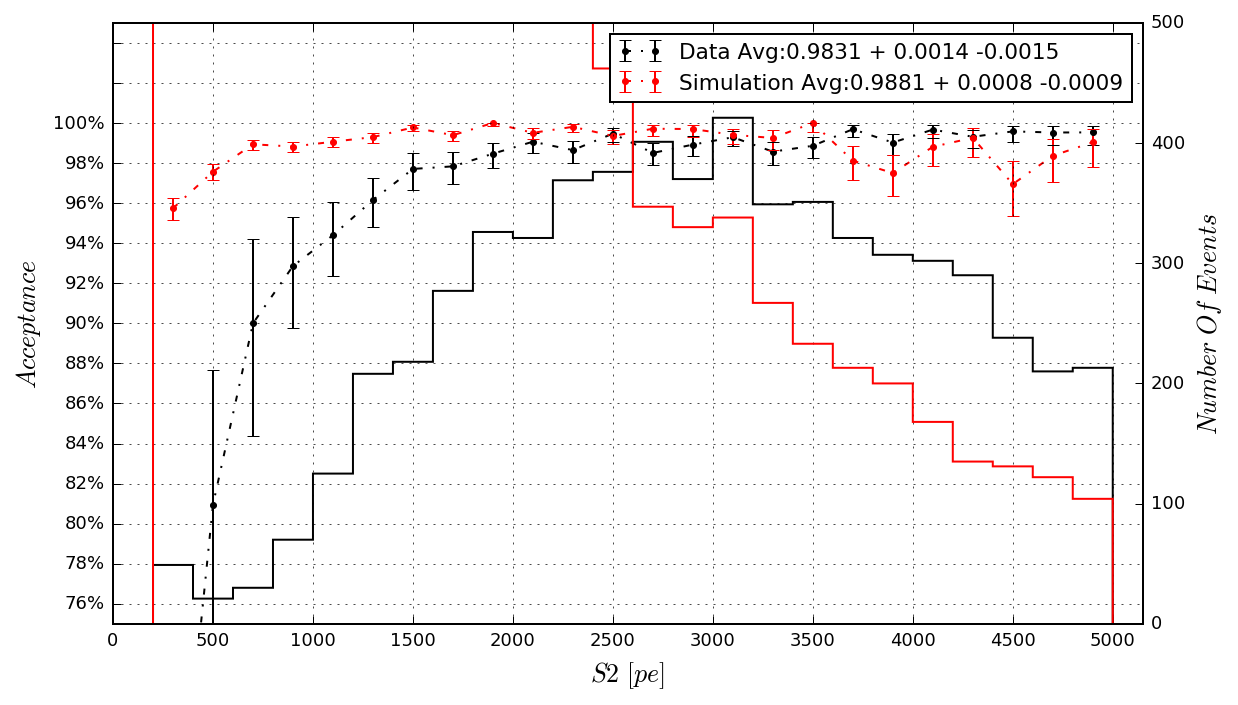

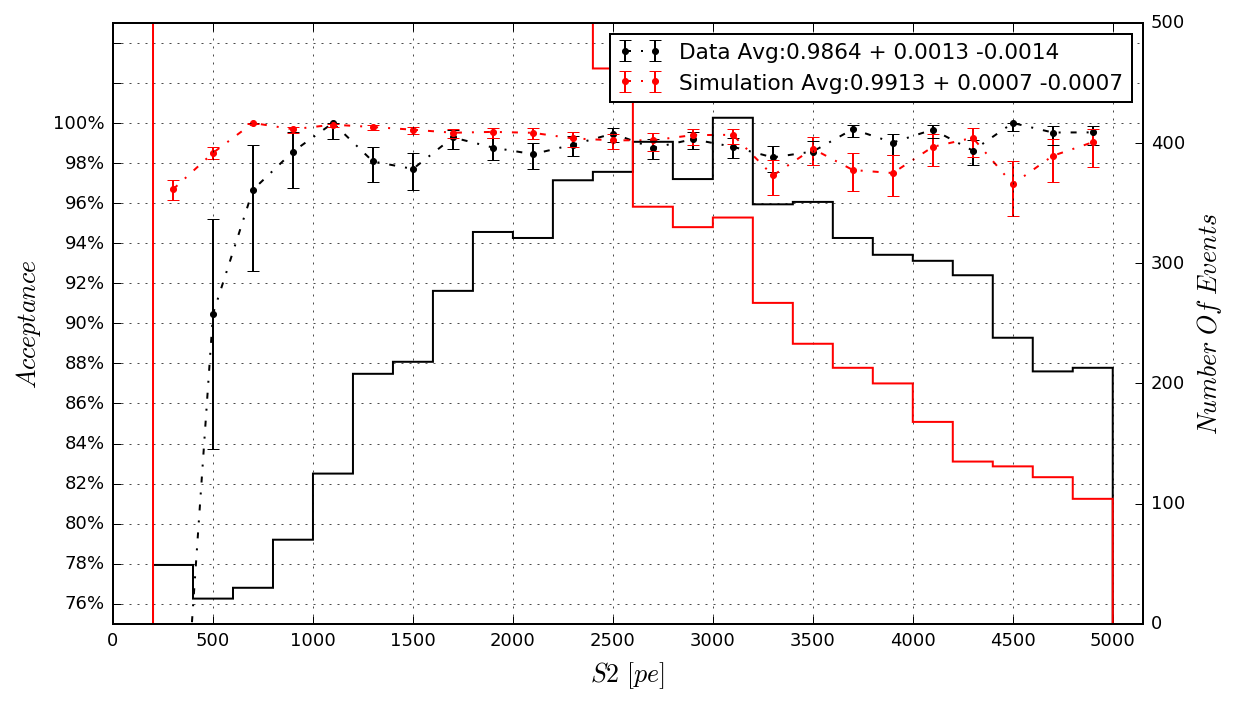

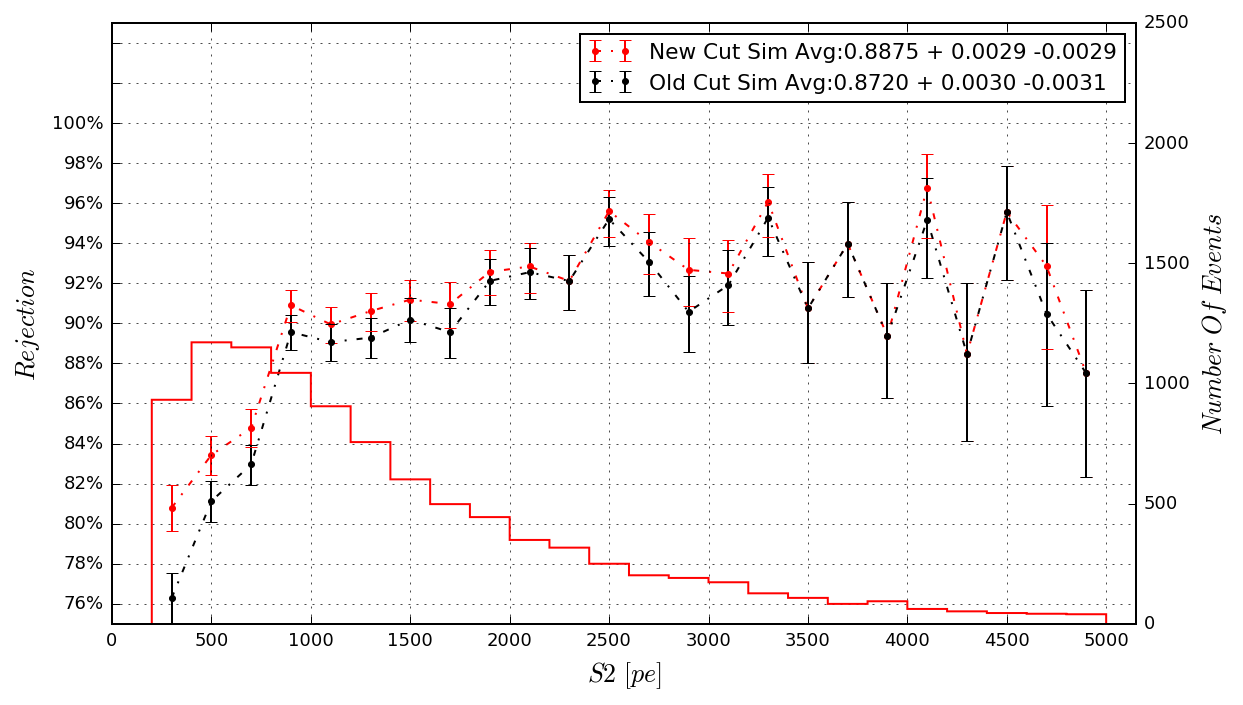

In [47]:
matplotlib.rc('font', size = 9)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['figure.figsize'] = (16, 5)
fig = plt.figure()
from scipy.stats import beta

class cut_efficiency():
    
    def __init__(self, cut, df):
        self.cut = cut
        self.df = df
        self.df['acc'] = np.asarray(df.eval(self.cut), dtype = int)
        
    def interval(self, q, rv):
        return rv.ppf(rv.cdf(q) + 0.6321) - q

    def efficicency_errors(self, accepted, total):
        
        if len(accepted) != len(total):
            print ('arrays must have same length')
            return 0
        
        index = range(len(accepted[:]))
        rv = [beta(accepted[i]+1,total[i]-accepted[i]+1) for i in index]
        bounds = [(rv[i].ppf(0),rv[i].ppf(0.3678)) for i in index]
        self.mod = [accepted[i]/total[i] for i in index]
        self.low = [self.mod[i] - minimize(self.interval, 0.1 ,rv[i], bounds=(bounds[i],)).x[0] for i in index]
        self.high = [self.interval(self.mod[i]-self.low[i],rv[i])-self.low[i] for i in index]
        
        return self.mod, self.low, self.high
    
    def plot(self, coo, arg = '', bounds = [200,5000], title = '', color = 'k'):
        
        global handles
        try: handles
        except: handles = []
            
        ax = fig.add_subplot(coo)
        
        self.mh = Histdd(self.df[arg], self.df['acc'],
                         bins=(np.linspace(bounds[0], bounds[1], 25), np.linspace(-0.5, 1.5, 3)))
        
        self.tot= self.mh.projection(axis=0)
        self.acc = self.mh.average(axis=1).histogram * self.tot.histogram
        
        mod, low, high = self.efficicency_errors(self.acc[:], self.tot[:])
        mod_total, low_total, high_total = self.efficicency_errors([sum(self.acc[:])],[sum(self.tot[:])])
        
        eline = plt.errorbar(self.tot.bin_centers, mod, yerr=[low, high], fmt='.', color=color, ls='-.', capsize=3.,
                             label = '%s Avg:%.4f + %.4f -%.4f' % (title,np.average(self.df.acc),high_total[0],low_total[0]))
        
        #line = plt.axhline(np.average(self.df.acc), xmin=0, xmax=1, color=color, ls='--', lw=1.,
        #                   label = '%s Avg:%.4f + %.4f -%.4f' % (title,np.average(self.df.acc),high_total[0],low_total[0]))
        
        handles.append(eline)
        labels = ['%d%%'%(i*2+76) for i in range(13)]
        plt.xticks(np.asarray([i*500 for i in range(13)]),color='k')
        plt.yticks(np.asarray([.76+i*0.02 for i in range(18)]),labels,color='k')
        ax.grid(which = 'minor', alpha = 0.3)
        ax.grid(which = 'major', alpha = 0.7)

        
######################## acceptance plots ########################
handles = []        

ce = cut_efficiency(sel_ss_string, df_rn_copy)
ce.plot(121, 's2', title = 'Data', color = 'k')

ce = cut_efficiency(sel_ss_string, df_fax)
ce.plot(121, 's2', title = 'Simulation', color = 'r')

plt_config(title = '', xbounds = [0,5150], ybounds = [0.75,1.05],
           xlabel = '$S2\ [pe]$', ylabel = '$Acceptance$',colorbar = False, sci = False)

ax = fig.add_subplot(121).twinx()
plt.hist(df_rn_copy.s2, bins = np.linspace(200, 5000, 25), color = 'k', label = 'Data Total', histtype = 'step')
plt.hist(df_fax.s2, bins = np.linspace(200, 5000, 25), color = 'r', label = 'Simulation Total', histtype = 'step')

plt_config(title = '', xbounds = [0,5150], ybounds = [0,500],
           xlabel = '$S2\ [pe]$', ylabel = '$Number\ Of\ Events$',colorbar = False, sci = False)

plt.legend(handles = handles, loc = 'upper right')

plt.tight_layout()
plt.show()


######################## acceptance plots old ########################
fig = plt.figure()
handles = []        

ce = cut_efficiency(sel_ss_string_old, df_rn_copy)
ce.plot(121, 's2', title = 'Data', color = 'k')

ce = cut_efficiency(sel_ss_string_old, df_fax)
ce.plot(121, 's2', title = 'Simulation', color = 'r')

plt_config(title = '', xbounds = [0,5150], ybounds = [0.75,1.05],
           xlabel = '$S2\ [pe]$', ylabel = '$Acceptance$',colorbar = False, sci = False)

ax = fig.add_subplot(121).twinx()
plt.hist(df_rn_copy.s2, bins = np.linspace(200, 5000, 25), color = 'k', label = 'Data Total', histtype = 'step')
plt.hist(df_fax.s2, bins = np.linspace(200, 5000, 25), color = 'r', label = 'Simulation Total', histtype = 'step')

plt_config(title = '', xbounds = [0,5150], ybounds = [0,500],
           xlabel = '$S2\ [pe]$', ylabel = '$Number\ Of\ Events$',colorbar = False, sci = False)

plt.legend(handles = handles, loc = 'upper right')

plt.tight_layout()
plt.show()

######################## rejection plots ########################
fig = plt.figure()
handles = []        

ce = cut_efficiency(sel_ms_string, df_full_more_ms)
ce.plot(122, 's2', title = 'New Cut Sim', color = 'r', bounds = [200,5000])
ce = cut_efficiency(sel_ms_string_old, df_full_more_ms)
ce.plot(122, 's2', title = 'Old Cut Sim', color = 'k', bounds = [200,5000])

plt_config(title = '', xbounds = [0,5150], ybounds = [0.75,1.05],
           xlabel = '$S2\ [pe]$', ylabel = '$Rejection$',colorbar = False, sci = False)

ax = fig.add_subplot(122).twinx()
#plt.hist(df_ab_copy.s2, bins = np.linspace(200, 5000, 25), color = 'k', label = 'Data Total', histtype = 'step')
plt.hist(df_full_more_ms.s2, bins = np.linspace(200, 5000, 25), color = 'r', label = 'Simulation Total', histtype = 'step')

plt_config(title = '', xbounds = [0,5150], ybounds = [0,2500],
           xlabel = '$S2\ [pe]$', ylabel = '$Number\ Of\ Events$',colorbar = False, sci = False)

plt.legend(handles = handles, loc = 'upper right')

plt.tight_layout()
plt.show()